## Purpose

In this project, we will an analysis on NVDA stock to determine if we want to open a position on it.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from datetime import date
import statsmodels.api as sm

import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [ ]:
nvda_prices = yf.download('NVDA', period='max')
nvda_prices.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376288,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415709,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383456,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382261,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381067,22752000


## Exploratory Data Analysis

* We will now conduct EDA to derive insights about NVDA, finding relationships between NVDA and microeconomic/macroeconomic factors.

<Axes: xlabel='Date', ylabel='Closing Price'>

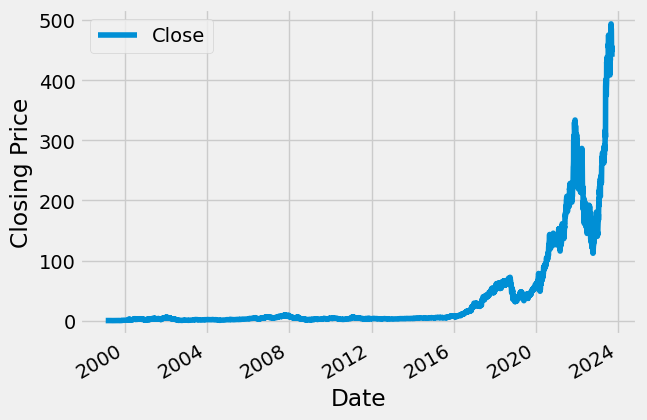

In [ ]:
#Visualize Nvidia's closing price over time
nvda_prices.index = pd.to_datetime(nvda_prices.index)
nvda_prices.plot.line(y="Close",ylabel="Closing Price",use_index=True)

# In this graph, we visualize Nvidia's closing price over time. We notice that the closing price only shifts after 2016, so we will explore the data from here on. This accounts for changes in the market, since we don't want to include "outdated" data.

In [ ]:
today = date.today().strftime("%Y-%m-%d")
start_date = "2016-01-01"
nvda = yf.download('NVDA', start_date, today)
nvda.reset_index(inplace = True)

pd.set_option('display.max_rows',None)
#Key summary statistics
nvda.describe()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1.939000e+03
mean,111.954978,114.045988,109.779354,111.999122,111.705128,5.014718e+07
std,103.531109,105.482220,101.374758,103.454492,103.517130,2.664110e+07
min,6.195000,6.390000,6.187500,6.305000,6.155776,9.788400e+06
25%,39.617500,40.205000,38.933750,39.568748,39.212749,3.328460e+07
50%,62.922501,63.542500,62.000000,62.897499,62.387302,4.472870e+07
75%,160.790001,164.379997,157.735001,161.456245,161.250923,5.978410e+07
max,502.160004,502.660004,489.579987,493.549988,493.509338,3.692928e+08


#Given that Nvidia's performance is highly influenced by their manufacturer, Taiwan Semiconductor, we will explore their performance as well. We will account for the political tensions between China and Taiwan as well, exploring its potential impact on Nvidia's price.

In [ ]:
tsm = yf.download('TSM', start_date, today)
tsm.reset_index(inplace = True)

pd.set_option('display.max_rows',None)
tsm.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,22.240000,22.299999,21.860001,22.090000,17.569923,9145100
1,2016-01-05,22.180000,22.420000,21.950001,21.950001,17.458574,7642100
2,2016-01-06,21.660000,21.709999,21.260000,21.340000,16.973389,8063200
3,2016-01-07,20.879999,21.379999,20.820000,21.100000,16.782497,11242800
4,2016-01-08,21.270000,21.400000,20.770000,20.809999,16.551840,9290700


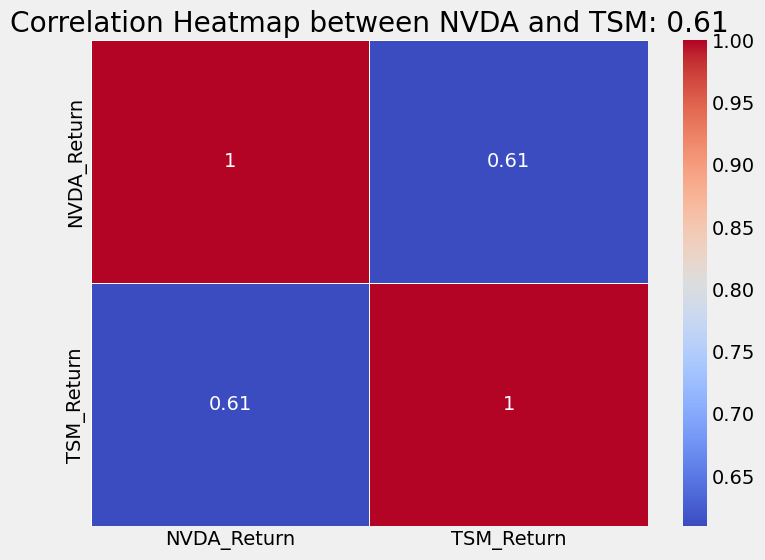

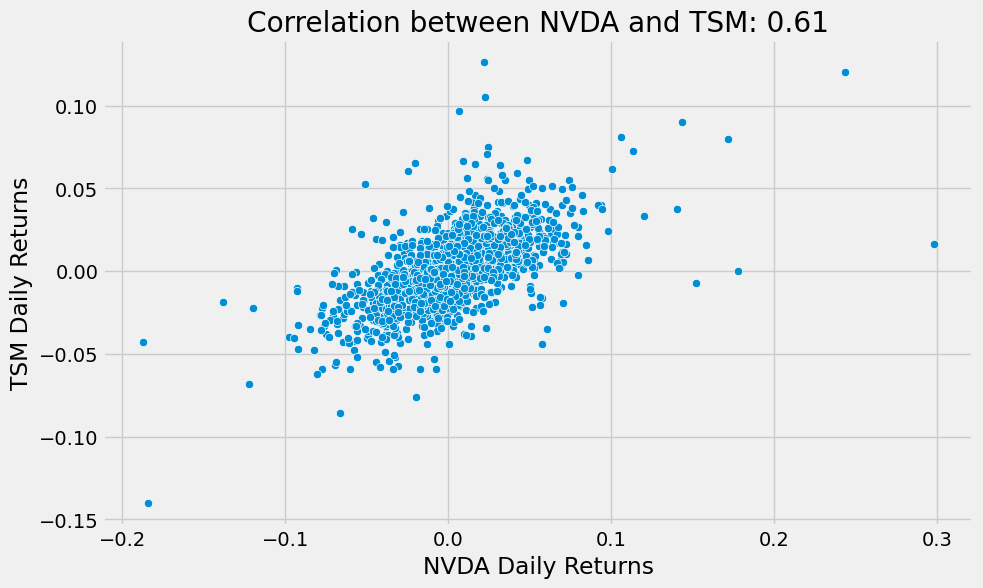

In [ ]:
#To compare the two stocks over time, we'll join the data into one data frame and visualize it.
joined_price = pd.merge(nvda, tsm, on='Date', suffixes=('_nvda', '_tsm'))

joined_price.rename(columns={
    'Open_nvda': 'NVDA_Open', 'High_nvda': 'NVDA_High', 'Low_nvda': 'NVDA_Low', 'Close_nvda': 'NVDA_Close', 'Volume_nvda': 'NVDA_Volume',
    'Open_tsm': 'TSM_Open', 'High_tsm': 'TSM_High', 'Low_tsm': 'TSM_Low', 'Close_tsm': 'TSM_Close', 'Volume_tsm': 'TSM_Volume'
}, inplace=True)

joined_price.dropna(inplace=True)

#Create new features of returns for each stock, showing their percent change in closing price
joined_price['NVDA_Return'] = joined_price['NVDA_Close'].pct_change()
joined_price['TSM_Return'] = joined_price['TSM_Close'].pct_change()

joined_price.dropna(inplace=True)

#Explore correlation between returns of each stock
correlation_coefficient = np.corrcoef(joined_price['NVDA_Return'], joined_price['TSM_Return'])[0, 1]
correlation_matrix = joined_price[['NVDA_Return', 'TSM_Return']].corr()

plt.figure(figsize=(8, 6))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Correlation Heatmap between NVDA and TSM: {correlation_coefficient:.2f}')
plt.show()

correlation_coefficient = np.corrcoef(joined_price['NVDA_Return'], joined_price['TSM_Return'])[0, 1]

plt.figure(figsize=(10, 6))
sn.scatterplot(data=joined_price, x='NVDA_Return', y='TSM_Return')
plt.title(f'Correlation between NVDA and TSM: {correlation_coefficient:.2f}')
plt.xlabel('NVDA Daily Returns')
plt.ylabel('TSM Daily Returns')
plt.grid(True)
plt.show()

# From this, we see that there is a moderately strong positive correlation between NVDA and TSM. Though TSM is crucial to Nvidia's  performance, there is not a major relationship in their changes in the past 5 years.

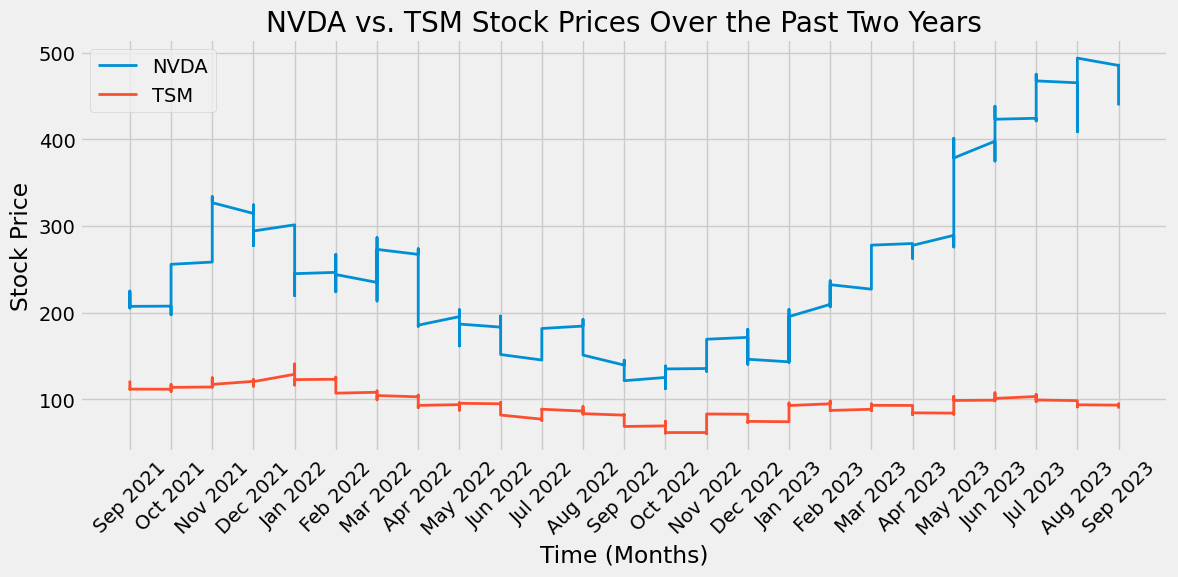

In [ ]:
# Reset the index to make 'Date' a regular column
joined_price.reset_index(inplace=True)

# Filter data for the past two years
two_years_ago = joined_price['Date'].max() - pd.DateOffset(years=2)
filtered_data = joined_price[joined_price['Date'] >= two_years_ago].copy()

# Create a 'Time' variable (in months) since the start date
filtered_data['Time'] = filtered_data['Date'].dt.strftime('%b %Y')

# Create a plot comparing the closing prices over time (in months)
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Time'], filtered_data['NVDA_Close'], label='NVDA', linewidth=2)
plt.plot(filtered_data['Time'], filtered_data['TSM_Close'], label='TSM', linewidth=2)
plt.xlabel('Time (Months)')
plt.ylabel('Stock Price')
plt.title('NVDA vs. TSM Stock Prices Over the Past Two Years')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# We note that the Taiwan-China tensions were especially high during this time period. Since Januaray 2022, there was a sharp and consistent increase in military excercises conducted by China in Taiwan. This peaked in **June 2022**, when there were over 400 Chinese military aircrafts spotted in Taiwan. In **April 2023**, China's military presence peaked again.

#From observing the trends in stock price for TSM and NVDA during these dates, we notice that there does NOT appear to be a substantial impact from the geopolitical events. This could be because of the high demand of AI in the current market and Nvidia's crucial role there. It suggests that the market dynamics and the company's strategic importance allowed it to continually perform despite geopolitical events, **showing Nvidia's strength and dependability.**

The feature we will be exploring is the closing price, as it reflects the daily performance of the stock. We also have a vast amount of historical data about closing price to move through.

In [ ]:
nvda_prices = nvda_prices.loc["2016-01-01":].copy() #Isolate data from 2016 onwards to account for market shifts
nvda_prices.dropna(inplace=True)
nvda_prices.head()

close_data = nvda_prices.filter(['Close'])
dataset = close_data.values
training_data_len = math.ceil(len(dataset) *0.8) #1548 rows to train model on
training_data_len

#Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(dataset)

scaled_prices

array([[0.00366859],
       [0.00393539],
       [0.00323759],
       ...,
       [0.92057387],
       [0.92254412],
       [0.88804402]])

## Predictive Modeling

* Create a model to forecast prices.
* Evaluate your model performance.
* Discuss pros/cons of the models you used.


# The model we'll be using is the Long Short Term Model to forecast Nvidia's stock price. This has the benefit of capturing long term and non-linear patterns in data, but has the downside of being prone to overfitting.

In [ ]:
#Create training data set and scaled training data set
train_data = scaled_prices[0:training_data_len, :]

x_train =[]
y_train =[]
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0]) #Append past 60 data values
  y_train.append(train_data[i, 0])
  if i<= 61:
    print(x_train)
    print(y_train)
    print()

[array([3.66858551e-03, 3.93539198e-03, 3.23759173e-03, 2.59623059e-03,
       2.26272202e-03, 2.28837705e-03, 2.54492150e-03, 2.07287967e-03,
       1.77015713e-03, 9.69738706e-04, 1.08261791e-03, 1.15958106e-03,
       1.32376935e-03, 1.65727792e-03, 1.64188490e-03, 1.78555015e-03,
       1.61109984e-03, 1.45204158e-03, 2.08827269e-03, 2.09340272e-03,
       1.45717258e-03, 1.52900570e-03, 1.53413572e-03, 6.20838091e-04,
       0.00000000e+00, 1.38534241e-04, 1.07749180e-04, 4.10470737e-05,
       2.61675462e-04, 9.08167606e-04, 1.25193722e-03, 2.47308937e-03,
       2.67832474e-03, 3.23246072e-03, 3.27350780e-03, 3.38638700e-03,
       3.42230307e-03, 3.31455487e-03, 3.15036658e-03, 3.86355985e-03,
       3.96104604e-03, 3.81225174e-03, 3.76094167e-03, 3.65319347e-03,
       3.35047094e-03, 3.34020892e-03, 3.31455487e-03, 3.59162335e-03,
       3.63266945e-03, 3.55057530e-03, 4.04314018e-03, 3.89947592e-03,
       4.40743480e-03, 4.45874291e-03, 4.42795687e-03, 4.72554937e-03,
     

In [ ]:
#Convert x_train to y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1492, 60, 1)

In [ ]:
#Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#compile model
model.compile(optimizer='adam', loss='mean_squared_error') #Loss sees how model performs, optimizer uses the loss to make improvements
model.fit(x_train, y_train, batch_size=1, epochs=1)


1492/1492 [==============================] - 49s 30ms/step - loss: 7.3663e-04


In [ ]:
#Create testing data set
test_data = scaled_prices[training_data_len-60: , :]
#Create data sets for x and y test
x_test = []
y_test = dataset[training_data_len :, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [ ]:
#Convert data to numpy array
x_test = np.array(x_test)
x_test.shape
#Reshape to 3d for LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1) )

In [ ]:
#Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 15ms/step


In [ ]:
#Get root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2 )
rmse
#A RMSE of 25 indicates a decent performing model

5.18604578220259

# We have an Root Mean Squared Error (RMSE) of 5, suggesting that on average the model's prediction of Nvidia's closing price tomorrow is about \$5 off. This is a relatively low RMSE given that Nvidia's stock price is high, currently in the range of over $400.

<ipython-input-18-aa9e043df878>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


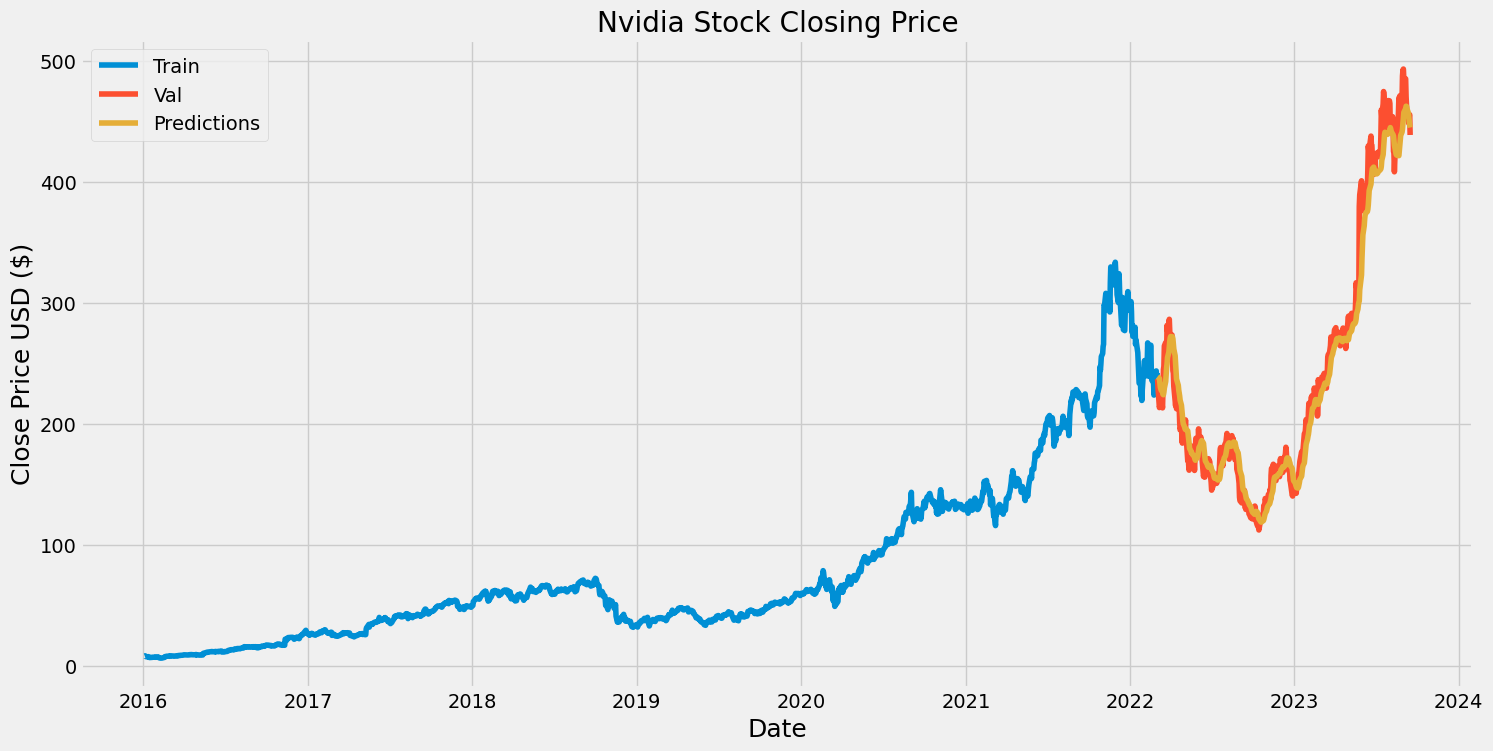

In [ ]:
#Plot performance and predictions
train = close_data[:training_data_len]
valid = close_data[training_data_len:]
valid['Predictions'] = predictions
#Visualize
plt.figure(figsize=(16,8))
plt.title('Nvidia Stock Closing Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

In [ ]:
#Show valid and predicted prices
valid.tail()

,Close,Predictions
Date,,
2023-09-11,451.779999,457.337067
2023-09-12,448.700012,453.580841
2023-09-13,454.850006,449.725952
2023-09-14,455.809998,446.996063
2023-09-15,439.000000,445.143463


In [ ]:
nvda2 = yf.download('NVDA',start_date,today)
nvda2 = nvda2.filter(['Close'])
#Get last 60 days of closing price values
prev_60 = nvda2[-60:].values
prev_60_scaled = scaler.transform(prev_60) # Scale

X_test = []
X_test.append(prev_60_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1) )
predicted_price = model.predict(X_test) #Get predicted scaled price
#undo scaling
predicted_price = scaler.inverse_transform(predicted_price)
print("The predicted price of tomorrow's closing price is $"+str(round(predicted_price[0][0], 2)))

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 25ms/step
The predicted price of tomorrow's closing price is $442.02


In [ ]:
nvda2.tail()

,Close
Date,
2023-09-11,451.779999
2023-09-12,448.700012
2023-09-13,454.850006
2023-09-14,455.809998
2023-09-15,439.000000


We see that our predicted price for September 15 is \$437.44 and the actual closing price was \$439.00.

## Recommendation

Based on the comprehensive analysis of NVIDIA's stock performance and other relevant factors, I would recommend **opening a position** on NVDA. The research indicates that NVIDIA's closing price has shown a consistent and resilient trend over the past five years, with significant attention paid to post-2016 data to account for market changes. While the company's performance is closely tied to its manufacturer, Taiwan Semiconductor (TSM), the moderately strong positive correlation between NVDA and TSM suggests that while TSM is influential, there hasn't been a major relationship shift in their performance during this period. Furthermore, despite heightened Taiwan-China tensions and significant geopolitical events, my analysis indicates that NVIDIA's stock has displayed a remarkable degree of stability, suggesting its strength and dependability in the face of external factors. The model, utilizing the Long Short-Term Memory (LSTM) technique, exhibits a relatively low Root Mean Squared Error (RMSE) of 5, indicating that, on average, the model's predictions of NVIDIA's closing price for the following day are within a \$5 margin of error, a promising result given the high stock price range of over \$400.

Though Nvidia's stock remained strong through the Taiwan-China conflict, it is possible Taiwan Semiconductor's performance will be hit as tensions rise. As a key manufacturer for Nvidia's AI semiconductors, this heightens the risk of the geopolitical conflict impacting Nvidia's stock price. From a microeconomic perspective, Nvidia operates in a highly competetive industry with rivals like AMD and Intel. In the widespread race for AI, intense competition can lead to pricing pressures and potentially impact NVDA's market share and profitability.